# 1- LeNet5 from scratch

In this project, at first, I want to implement the LeNet5 architecture from scratch, just using numpy package. I train the network for few epochs to see how it works. 
For training the network, I use just few training data. After that, I perform the LeNet5 architecture with Keras on my GPU. 
Then, I visualize all filters for its convolutional layers. 
Finally, I pass an image from the dataset over the network, and visualize all feature maps for convolutional layers.

Let's take a look at the architecture to know which layers we need to write.

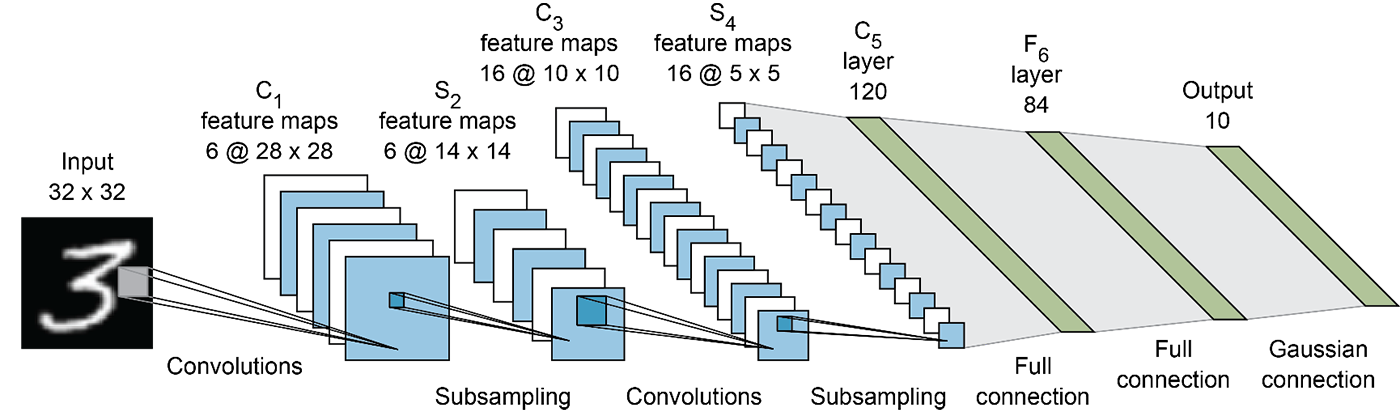

In [1]:
from IPython.display import Image
Image("Lenet5.png")

I am going to train the Lenet5 network with MNIST dataset from Keras, therefore,
I consider the input shape as 28 * 28 images. Also, I will use relu function as activation.
Now, it's time to costruct all layers I will need to implement the network.

In [2]:
import numpy as np

#convolution for a 3-dimensional data and a 3-dimensional filter
def convolution(feature_maps, conv_filter, bias, stride = 1):
    w_feature_maps, h_feature_maps = feature_maps.shape[0:2]
    w_conv_filter, h_conv_filter = conv_filter.shape[0:2]
    w_new_feature_map = int((w_feature_maps - w_conv_filter) / stride ) + 1
    h_new_feature_map = int((h_feature_maps - h_conv_filter) / stride ) + 1
    new_feature_map = np.zeros((w_new_feature_map, h_new_feature_map))
    for i in range(w_new_feature_map):
        for j in range(h_new_feature_map):
            feature_map_cropped = feature_maps[i*stride:i*stride+w_conv_filter, j*stride:j*stride+h_conv_filter, :]
            new_feature_map[i, j] = np.sum(feature_map_cropped * conv_filter) + bias
    return new_feature_map

#convolution for a 3-dimensional data and a set of 3-dimensional filters
def convolution_layer(feature_maps, conv_filters, bias, stride=1):
    w_feature_maps, h_feature_maps, number_feature_maps = feature_maps.shape
    w_conv_filters, h_conv_filters, number_feature_maps, number_filters = conv_filters.shape
    list_maps = []
    for i in range(number_filters):
        new_feature_map = convolution(feature_maps, conv_filters[:, :, :, i], bias[i], stride)
        list_maps.append(new_feature_map)
    new_feature_maps = np.stack(list_maps, axis=2)
    return new_feature_maps

#convolution for a batch including 3-dimensional data and a set of 3-dimensional filters
def Conv2D(batch_data, conv_filters, bias, stride=1):
    number_data = batch_data.shape[0]
    list_new_batch = []
    for i in range(number_data):
        new_data = convolution_layer(batch_data[i,:,:,:], conv_filters, bias, stride)
        list_new_batch.append(new_data)
    new_batch = np.stack(list_new_batch, axis=0)
    return new_batch

#pooling for a 2-dimensional data
def AvgPool(feature_map, pool_size=2, stride=2):
    w_feature_map, h_feature_map = feature_map.shape[0: 2]
    w_new_feature_map = int((w_feature_map - pool_size)/stride) + 1
    h_new_feature_map = int((h_feature_map - pool_size)/stride) + 1 
    new_feature_map = np.zeros((w_new_feature_map, h_new_feature_map))
    for i in range(w_new_feature_map):
        for j in range(h_new_feature_map):
            feature_map_cropped = feature_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            new_feature_map[i, j] = np.mean(feature_map_cropped)
    return new_feature_map

#pooling for a 3-dimensional data
def AvgPool_layer(feature_maps, pool_size=2, stride=2):
    number_maps = feature_maps.shape[2]
    list_maps = []
    for i in range(number_maps):
        new_feature_map = AvgPool(feature_maps[:, :, i], pool_size, stride)
        list_maps.append(new_feature_map)
    new_feature_maps = np.stack(list_maps, axis=2)
    return new_feature_maps

#pooling for a batch including 3-dimensional data
def AveragePooling2D(batch_data, pool_size=2, stride=2):
    number_data = batch_data.shape[0]
    list_new_batch = []
    for i in range(number_data):
        new_data = AvgPool_layer(batch_data[i,:,:,:], pool_size, stride)
        list_new_batch.append(new_data)
    new_batch = np.stack(list_new_batch, axis=0)
    return new_batch

def relu(input_value):
    return np.maximum(input_value, 0)

def relu_backward(doutput, input_value):
    dinput_value = doutput.copy()
    dinput_value[input_value <= 0] = 0
    return dinput_value

#backward pooling for a 2-dimensional data
def AvgPool_backward(doutput_feature_map, input_feature_map, pool_size=2, stride=2):
    w_new_feature_map, h_new_feature_map = doutput_feature_map.shape[0: 2]
    dinput_feature_map = np.zeros((input_feature_map.shape))
    for i in range(w_new_feature_map):
        for j in range(h_new_feature_map):
            dinput_feature_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size] += np.full((pool_size, pool_size), (doutput_feature_map[i, j])/pool_size**2)
    return dinput_feature_map

#backward pooling for a 3-dimensional data
def AvgPool_layer_backward(doutput_feature_maps, input_feature_maps, pool_size=2, stride=2):
    number_maps = input_feature_maps.shape[2]
    list_maps = []
    for i in range(number_maps):
        new_feature_map = AvgPool_backward(doutput_feature_maps[:, :, i], input_feature_maps[:, :, i], pool_size, stride)
        list_maps.append(new_feature_map)
    new_feature_maps = np.stack(list_maps, axis=2)
    return new_feature_maps

#backward pooling for a batch including 3-dimensional data
def AveragePooling2D_backward(doutput_batch_data, input_batch_data, pool_size=2, stride=2):
    number_data = input_batch_data.shape[0]
    list_new_batch = []
    for i in range(number_data):
        new_data = AvgPool_layer_backward(doutput_batch_data[i,:,:,:], input_batch_data[i,:,:,:], pool_size, stride)
        list_new_batch.append(new_data)
    new_batch = np.stack(list_new_batch, axis=0)
    return new_batch

#backward convolution for a batch including 3-dimensional data and a set of 3-dimensional filters
def Conv2D_backward(doutput_batch_data, input_batch_data, conv_filters, bias, stride=1):
    number_data = input_batch_data.shape[0]
    w_conv_filter, h_conv_filter = conv_filters.shape[0:2]
    number_data, w_feature_maps, h_feature_maps, number_channels = doutput_batch_data.shape
    dinput_batch_data = np.zeros((input_batch_data.shape))                           
    dconv_filters = np.zeros((conv_filters.shape))
    dbias = np.zeros((bias.shape)).T
    
    for n in range(number_data):
        feature_map = input_batch_data[n]
        dfeature_map = dinput_batch_data[n]

        for i in range(w_feature_maps):
            for j in range(h_feature_maps):
                for c in range(number_channels):
                    feature_map_cropped = feature_map[i*stride:i*stride+w_conv_filter, j*stride:j*stride+h_conv_filter, :]
                    dfeature_map[i*stride:i*stride+w_conv_filter, j*stride:j*stride+h_conv_filter, :] += conv_filters[:,:,:,c] * doutput_batch_data[n, i, j, c]
                    dconv_filters[:,:,:,c] += feature_map_cropped * doutput_batch_data[n, i, j, c]
                    dbias[:,c] += doutput_batch_data[n, i, j, c]
        dinput_batch_data[n, :, :, :] = dfeature_map
    return dinput_batch_data, dconv_filters, dbias.T


def softmax_loss_and_crossentropy(output, y):
    y = y.argmax(axis = 1)
    batch_size, num_classes = output.shape
    shifted_logits = output - np.max(output, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    loss = -np.sum(log_probs[range(batch_size), y]) /batch_size
    doutput = probs.copy()
    doutput[range(batch_size), y] -= 1
    doutput /= batch_size
    return loss, doutput     

Now, I write other functions required to perform the network.

In [3]:
# function to suffle data
def shuffle_data(x, y):
    p = np.random.permutation(len(x))
    return x[p], y[p]

#random initilization of filters of a convolutional layer
def convolution_filter_initializer(filter_size):
    filter_weights = np.random.standard_normal(size=filter_size) / (np.sqrt(np.prod(filter_size)))
    return filter_weights

#random initilization of weights of a dense layer
def dense_params_initializer(weight_size):
    w = np.random.standard_normal(weight_size) * 0.01
    return w

Finally, I will construct the network and its related functions.

In [4]:
#initializing all parameters of Lenet5 network
def lenet5_initialize_parameters():
    f1 = convolution_filter_initializer((3, 3, 1, 6))
    f2 = convolution_filter_initializer((3, 3, 6, 16))
    w3 = dense_params_initializer((400, 120))
    w4 = dense_params_initializer((120, 84))
    w5 = dense_params_initializer((84, 10))
    b1 = np.zeros((6, 1))
    b2 = np.zeros((16, 1))
    b3 = np.zeros((1, 120))
    b4 = np.zeros((1, 84))
    b5 = np.zeros((1, 10))
    weights = f1, b1, f2, b2, w3, b3, w4, b4, w5, b5
    return weights

#initializing required momentum and rmsprop parameters to use in AdamGD algorithm
def lenet5_initialize_adam_parameters(weights):
    f1, b1, f2, b2, w3, b3, w4, b4, w5, b5 = weights
    vf1 = np.zeros(f1.shape)
    vf2 = np.zeros(f2.shape)
    vw3 = np.zeros(w3.shape)
    vw4 = np.zeros(w4.shape)
    vw5 = np.zeros(w5.shape)
    
    vb1 = np.zeros(b1.shape)
    vb2 = np.zeros(b2.shape)
    vb3 = np.zeros(b3.shape)
    vb4 = np.zeros(b4.shape)
    vb5 = np.zeros(b5.shape)
    
    mf1 = np.zeros(f1.shape)
    mf2 = np.zeros(f2.shape)
    mw3 = np.zeros(w3.shape)
    mw4 = np.zeros(w4.shape)
    mw5 = np.zeros(w5.shape)
    
    mb1 = np.zeros(b1.shape)
    mb2 = np.zeros(b2.shape)
    mb3 = np.zeros(b3.shape)
    mb4 = np.zeros(b4.shape)
    mb5 = np.zeros(b5.shape)
    
    trained_epochs_adam = 0
    
    momentum_adam_parameters = [mf1, mb1, mf2, mb2, mw3, mb3, mw4, mb4, mw5, mb5]
    rmsprop_adam_parameters = [vf1, vb1, vf2, vb2, vw3, vb3, vw4, vb4, vw5, vb5]
    adam_parameters = momentum_adam_parameters, rmsprop_adam_parameters, trained_epochs_adam
    
    return adam_parameters

def lenet5_epoch(x0, y0, weights):
    # forward #
    f1, b1, f2, b2, w3, b3, w4, b4, w5, b5 = weights
    z1 = Conv2D(x0, f1, b1)
    a1 = relu(z1)
    x1 = AveragePooling2D(a1)
    z2 = Conv2D(x1, f2, b2)
    a2 = relu(z2)
    x2 = AveragePooling2D(a2)
    x3 = x2.reshape(x2.shape[0],-1)
    z3 = np.dot(x3, w3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, w4) + b4
    a4 = relu(z4)
    output = np.dot(a4, w5) + b5
    loss, doutput = softmax_loss_and_crossentropy(output, y0)
    
    # backward #
    dw5 = a4.T.dot(doutput)
    db5 = np.sum(doutput, axis = 0, keepdims=True)
    da4 = doutput.dot(w5.T)
    dz4 = relu_backward(da4, z4)
    dw4 = a3.T.dot(dz4)
    db4 = np.sum(dz4, axis = 0, keepdims=True)
    da3 = dz4.dot(w4.T)
    dz3 = relu_backward(da3, z3)
    dw3 = x3.T.dot(dz3)
    db3 = np.sum(dz3, axis = 0, keepdims=True)
    dx3 = dz3.dot(w3.T)
    dx2 = dx3.reshape(x2.shape)
    da2 = AveragePooling2D_backward(dx2, a2)
    dz2 = relu_backward(da2, z2)
    dx1, df2, db2 = Conv2D_backward(dz2, x1, f2, b2)
    da1 = AveragePooling2D_backward(dx1, a1)
    dz1 = relu_backward(da1, z1)
    dx0, df1, db1 = Conv2D_backward(dz1, x0, f1, b1)
    
    dweights = df1, db1, df2, db2, dw3, db3, dw4, db4, dw5, db5
    return dweights, loss

    
def lenet5_update_adam(weights, dweights, adam_parameters, lr, beta1, beta2, epsilon):
    list_weights = list(weights)
    momentum_adam_parameters, rmsprop_adam_parameters, trained_epochs_adam = adam_parameters
    trained_epochs_adam += 1
    for i in range(len(list_weights)):
        m = beta1 * momentum_adam_parameters[i] + (1-beta1) * dweights[i]
        momentum_adam_parameters[i] = m
        v = beta2 * rmsprop_adam_parameters[i] + (1-beta2) * ( dweights[i] ** 2 )
        rmsprop_adam_parameters[i] = v
        mb = m / ( 1 - beta1 ** trained_epochs_adam)
        mv = v / ( 1 - beta2 ** trained_epochs_adam)
        list_weights[i] -= lr * mb / (np.sqrt(mv) + epsilon)
    weights = tuple(list_weights)
    adam_parameters = momentum_adam_parameters, rmsprop_adam_parameters, trained_epochs_adam
    return weights, adam_parameters



def lenet5_predict(x0, weights):
    f1, b1, f2, b2, w3, b3, w4, b4, w5, b5 = weights
    z1 = Conv2D(x0, f1, b1)
    a1 = relu(z1)
    x1 = AveragePooling2D(a1)
    z2 = Conv2D(x1, f2, b2)
    a2 = relu(z2)
    x2 = AveragePooling2D(a2)
    x3 = x2.reshape(x2.shape[0],-1)
    z3 = np.dot(x3, w3) + b3
    a3 = relu(z3)
    z4 = np.dot(a3, w4) + b4
    a4 = relu(z4)
    output = np.dot(a4, w5) + b5
    shifted_logits = output - np.max(output, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    prediction = probs.argmax(axis=1)
    
    return prediction
    

def lenet5_accuracy(x0, y0, weights):
    y0 = y0.argmax(axis=1)
    prediction = lenet5_predict(x0, weights)
    return 100*np.mean(prediction == y0)
    

def lenet5_train_adam(x_train, y_train,lr=0.01,beta1=0.9,beta2=0.999,batch_size=16,num_epochs=10, epsilon=1e-7):
    toatal_loss = []
    weights = lenet5_initialize_parameters()
    adam_parameters = lenet5_initialize_adam_parameters(weights)
    for epoch in range(num_epochs):
        x_train, y_train = shuffle_data(x_train, y_train)
        print("epoch : ", epoch + 1)
        number_data = y_train.shape[0]
        number_batches = y_train.shape[0] // batch_size
        for batch in range(0, number_batches * batch_size, batch_size):
            x0 = x_train[batch:batch + batch_size, :, :, :]
            y0 = y_train[batch:batch + batch_size, :]
            dweights, loss = lenet5_epoch(x0, y0, weights)
            print(f'loss over batch {batch + 1} : ', loss)
            toatal_loss.append(loss)
            weights, adam_parameters = lenet5_update_adam(weights, dweights, adam_parameters, lr,beta1,beta2, epsilon)
        print('accuracy : ',lenet5_accuracy(x_train, y_train, weights))
    return weights, dweights, adam_parameters, toatal_loss

I use the MNIST dataset from Keras, and manually split dataset.

In [5]:
from keras.datasets import mnist
from keras.utils import np_utils
# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

#choose a subset of dataset to work on
x_train, y_train = x_train[:20000,:,:,:], y_train[:20000]
x_val, y_val = x_test[:5000,:,:,:], y_test[:5000]
x_test, y_test = x_test[5000:,:,:,:], y_test[5000:]

Using TensorFlow backend.


To see how the network works, I need to train the network in some epochs, but I will use just few training data.

In [6]:
number_training_data = 4
x_train_lenet5, y_train_lenet5 = x_train[:number_training_data, :, :, :], y_train[:number_training_data, :]

weights, dweights, adam_parameters, total_loss = lenet5_train_adam(x_train_lenet5, y_train_lenet5, batch_size=4, num_epochs=40)

epoch :  1
loss over batch 1 :  2.3025841870995247
accuracy :  25.0
epoch :  2
loss over batch 1 :  2.2845526961890763
accuracy :  25.0
epoch :  3
loss over batch 1 :  2.2197777414814333
accuracy :  25.0
epoch :  4
loss over batch 1 :  1.9722350204624308
accuracy :  25.0
epoch :  5
loss over batch 1 :  1.5299160715713935
accuracy :  25.0
epoch :  6
loss over batch 1 :  1.3962140018725955
accuracy :  25.0
epoch :  7
loss over batch 1 :  1.7085320859293147
accuracy :  25.0
epoch :  8
loss over batch 1 :  1.5049806083961652
accuracy :  25.0
epoch :  9
loss over batch 1 :  1.5315562220345083
accuracy :  25.0
epoch :  10
loss over batch 1 :  1.435854290437038
accuracy :  25.0
epoch :  11
loss over batch 1 :  1.406471816854781
accuracy :  25.0
epoch :  12
loss over batch 1 :  1.4106930782065965
accuracy :  25.0
epoch :  13
loss over batch 1 :  1.3990172869166133
accuracy :  25.0
epoch :  14
loss over batch 1 :  1.384778207121499
accuracy :  25.0
epoch :  15
loss over batch 1 :  1.37823229314

Therefore, the network is able to learn how to classify images properly. In fact, I used just 4 training images,
 and certainly the model is overfitted. However, now I am sure that my implementation works fine. In addition, the first loss, 
 related to the initialized parameters, 
 is about 2.3, which shows that I have implemented loss function properly. To see more details,
  I will plot the loss values over iterations.

Text(0, 0.5, 'Loss')

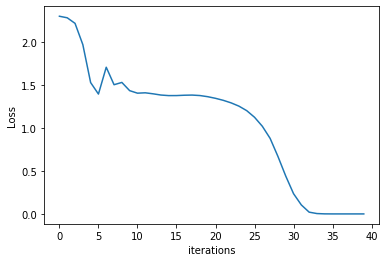

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_loss)
plt.xlabel('iterations')
plt.ylabel('Loss')

# 2- Lent5 with Keras
In this section, I want to implement the same network with Keras. I will train the Lenet5 with a large dataset, to use for visualization in the next sections.

In [9]:
import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, AveragePooling2D, Conv2D, Flatten

In [10]:
# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

#choose a subset of dataset to work on
x_train, y_train = x_train[:10000,:,:,:], y_train[:10000]
x_val, y_val = x_test[:5000,:,:,:], y_test[:5000]
x_test, y_test = x_test[5000:,:,:,:], y_test[5000:]

In [11]:
model = Sequential(name = 'Lenet5')

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))

model.add(Dense(units=10, activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = 'Adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "Lenet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164

In [13]:
hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val), verbose=1)

Train on 10000 samples, validate on 5000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 277us/step - loss: 1.0922 - accuracy: 0.6841 - val_loss: 0.5356 - val_accuracy: 0.8462
Epoch 2/10
10000/10000 [==============================] - 1s 108us/step - loss: 0.3682 - accuracy: 0.8910 - val_loss: 0.4139 - val_accuracy: 0.8782
Epoch 3/10
10000/10000 [==============================] - 1s 107us/step - loss: 0.2816 - accuracy: 0.9183 - val_loss: 0.3061 - val_accuracy: 0.9072
Epoch 4/10
10000/10000 [==============================] - 1s 108us/step - loss: 0.2272 - accuracy: 0.9344 - val_loss: 0.2699 - val_accuracy: 0.9142
Epoch 5/10
10000/10000 [==============================] - 1s 109us/step - loss: 0.1917 - accuracy: 0.9436 - val_loss: 0.2348 - val_accuracy: 0.9260
Epoch 6/10
10000/10000 [==============================] - 1s 108us/step - loss: 0.1508 - accuracy: 0.9573 - val_loss: 0.2012 - val_accuracy: 0.9400
Epoch 7/10
10000/10000 [==============================] - 1s 10

In [14]:
test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

5000/5000 [==============================] - 1s 119us/step
Test loss 0.0747, accuracy 97.92%


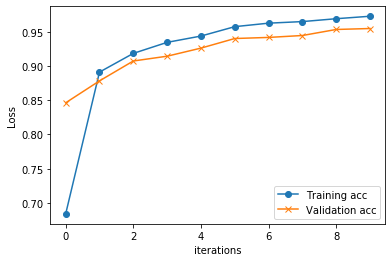

In [15]:
plt.plot(hist.history['accuracy'], 'o-', label='Training acc')
plt.plot(hist.history['val_accuracy'], 'x-', label='Validation acc')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()

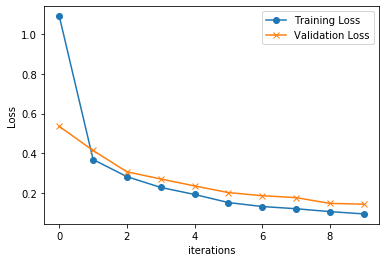

In [16]:
plt.plot(hist.history['loss'], 'o-', label='Training Loss')
plt.plot(hist.history['val_loss'], 'x-', label='Validation Loss')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()

# 3 - Visulizing Filters
In this section, I am going to visualize all filters of all convolutional layers. So, let's
 take a look at the networks' layers to see which layers are convolutional.

In [17]:
model.layers

# 3.1 - Visulizing Filters : 1st Convolutional Layer

filter sizes :  (3, 3, 1, 6)


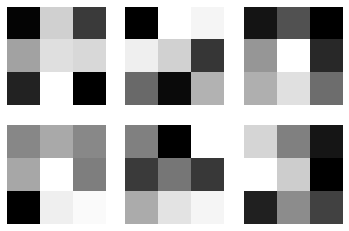

In [18]:
# retrieve weights from the first convolutional layer
filters, biases = model.layers[0].get_weights()
print('filter sizes : ', filters.shape)

# normalize filter values
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[3]
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(f.shape[2]):
        plt.subplot(2, 3, i+1)
        plt.imshow(f[:, :, j], cmap='gray')
        plt.axis('off')

# 3.2- Visulizing Filters : 2nd convolutional layer

filter sizes :  (3, 3, 6, 16)


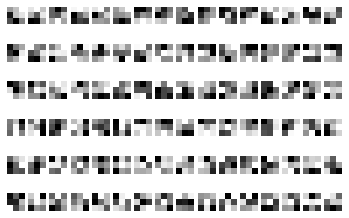

In [19]:
# retrieve weights from the second convolutional layer
filters, biases = model.layers[2].get_weights()
print('filter sizes : ', filters.shape)

# normalize filter values
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[3]
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(f.shape[2]):
        plt.subplot(6, n_filters, 6*i+j+1)
        plt.imshow(f[:, :, j], cmap='gray')
        plt.axis('off')

# 4 - Visualizing Feature Maps
I am going to visulalize feature maps of the network, to see how the filters affect input images. For doing visualization, 
I will pass an image through the network, and then, show its all feature maps. I choose the first image in the testing dataset.

input_map shape is :  (1, 28, 28, 1)


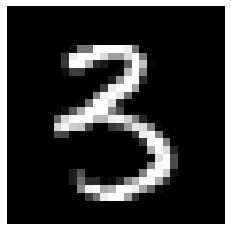

In [20]:
input_map = x_test[0]
plt.imshow(input_map[:, :, 0], cmap = 'gray')
plt.axis("off")
# Reshape the data into 4D array
input_map = input_map[None, :]
print('input_map shape is : ', input_map.shape)

In [21]:
from keras.models import Model
#indices of convolutional layers
ixs = [0, 2]
outputs = [model.layers[i].output for i in ixs]
# redefine model to output the convolutional layers
model2 = Model(inputs=model.inputs, outputs=outputs)
# get feature maps
feature_maps = model2.predict(input_map)
print('output shape of the first convolotional layer : ', feature_maps[0].shape)
print('output shape of the second convolotional layer : ', feature_maps[1].shape)

output shape of the first convolotional layer :  (1, 26, 26, 6)
output shape of the second convolotional layer :  (1, 11, 11, 16)


As we know, there are 6 feature maps and 16 feature maps for the first and second convolutional layers, respectively. 
I will visualize all these feature maps separately.

# 4.1 - Visualizing 1st convolutional layer's feature maps

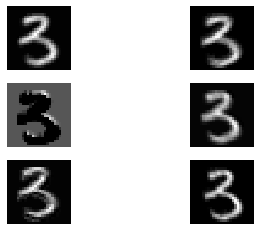

In [22]:
# get feature maps for first convolutional layer
maps = feature_maps[0]
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(maps[0, :, :, i], cmap = 'gray')
    plt.axis('off')

# 4.2 - Visualizing 2nd convolutional layer's feature maps

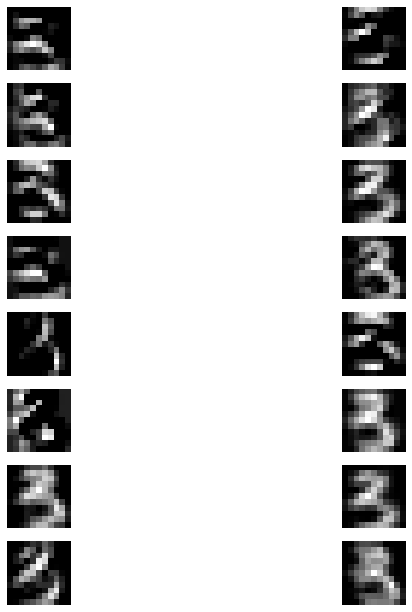

In [23]:
# get feature maps for second convolutional layer
maps = feature_maps[1]
plt.figure(figsize=(11, 11))
for i in range(16):
    plt.subplot(8, 2, i+1)
    plt.imshow(maps[0, :, :, i], cmap = 'gray')
    plt.axis('off')